# 3 - Análise Exploratória de Séries Temporais - Faturamento do produto `saude`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `alimenticio`.

In [2]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [3]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'saude'
fat = tswide[analise_produto].dropna()

In [4]:
fat

date
2016-11-01    0.000000e+00
2016-12-01    5.594537e+06
2017-01-01    7.946243e+06
2017-02-01    1.008665e+07
2017-03-01    1.097331e+07
2017-04-01    1.279503e+07
2017-05-01    1.242508e+07
2017-06-01    1.384395e+07
2017-07-01    1.479411e+07
2017-08-01    1.632695e+07
2017-09-01    1.408867e+07
2017-10-01    1.641772e+07
2017-11-01    1.700685e+07
2017-12-01    1.756095e+07
2018-01-01    1.821515e+07
2018-02-01    1.883889e+07
2018-03-01    1.951789e+07
2018-04-01    2.059776e+07
2018-05-01    1.967622e+07
2018-06-01    2.050597e+07
2018-07-01    2.006257e+07
2018-08-01    2.152374e+07
2018-09-01    2.198473e+07
2018-10-01    2.052640e+07
2018-11-01    2.036836e+07
2018-12-01    2.171106e+07
2019-01-01    2.140601e+07
2019-02-01    2.118607e+07
2019-03-01    2.352998e+07
2019-04-01    2.339832e+07
2019-05-01    2.122847e+07
2019-06-01    2.261791e+07
2019-07-01    2.297949e+07
2019-08-01    2.288370e+07
2019-09-01    2.365614e+07
2019-10-01    2.338761e+07
2019-11-01    2.402938e

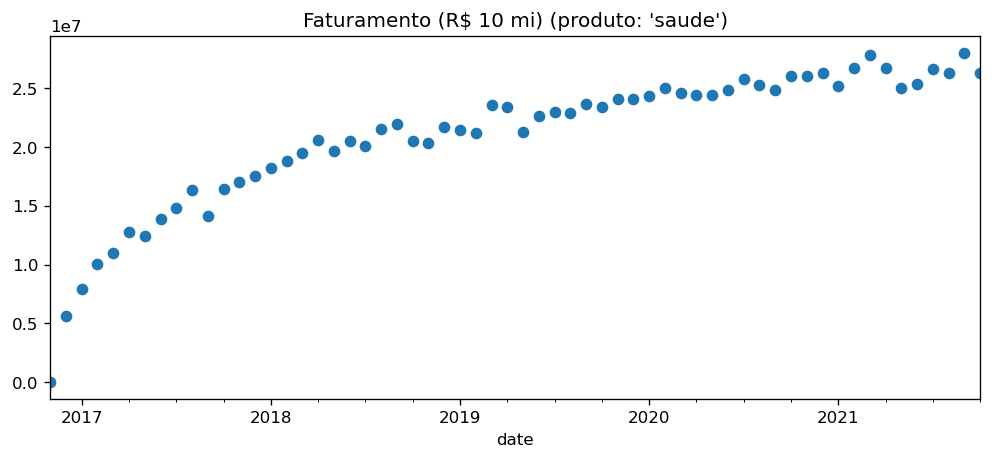

In [6]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ 10 mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [7]:
fat.describe()

count    6.000000e+01
mean     2.089162e+07
std      5.826385e+06
min      0.000000e+00
25%      1.868296e+07
50%      2.275080e+07
75%      2.502346e+07
max      2.800000e+07
Name: saude, dtype: float64

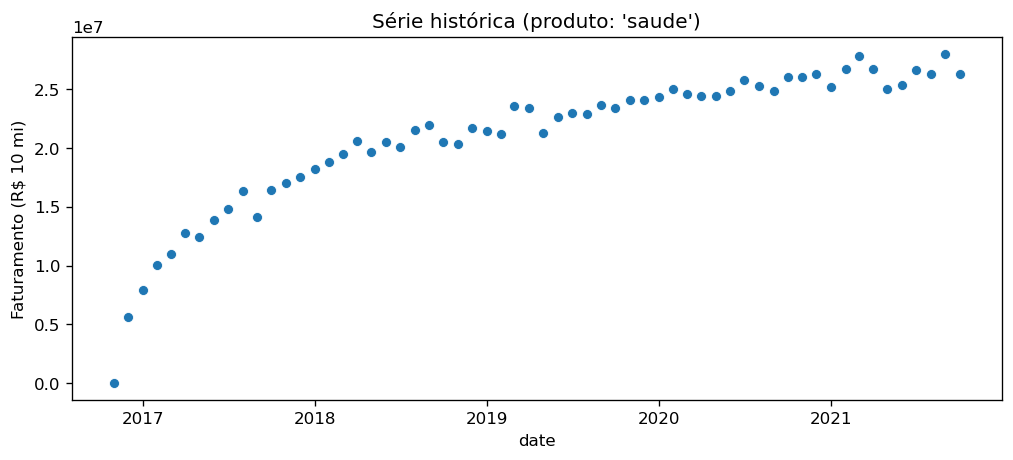

In [8]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 10 mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

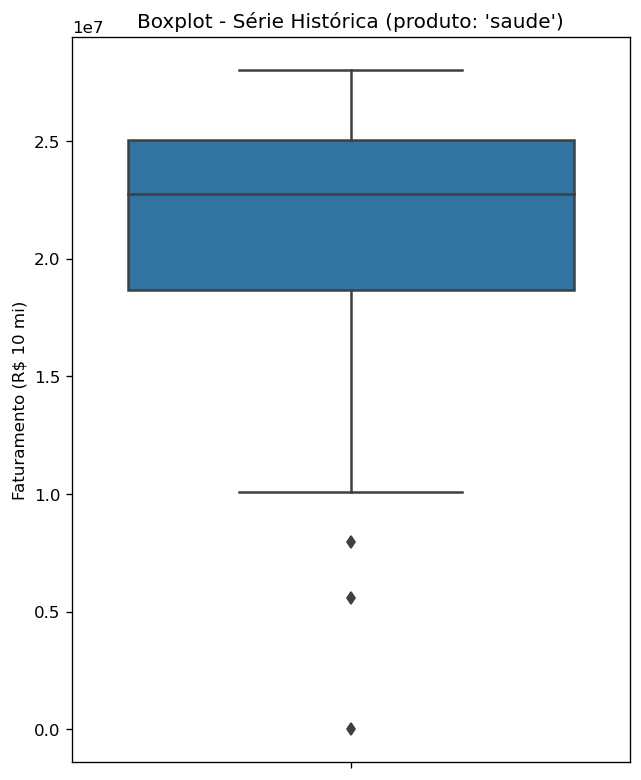

In [9]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ 10 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Os *outliers* da série histórica indicados no *boxplot* acima são provavelmente os valores baixo durante o *ramp-up* do produto.

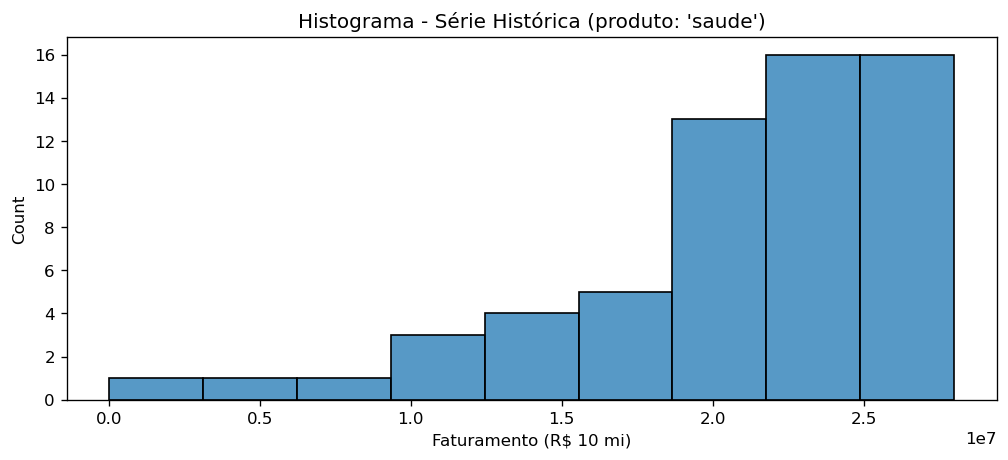

In [10]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ 10 mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [11]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     2.367604e+07
std      2.413237e+06
min      1.883889e+07
25%      2.152374e+07
50%      2.404184e+07
75%      2.530390e+07
max      2.800000e+07
Name: saude, dtype: float64

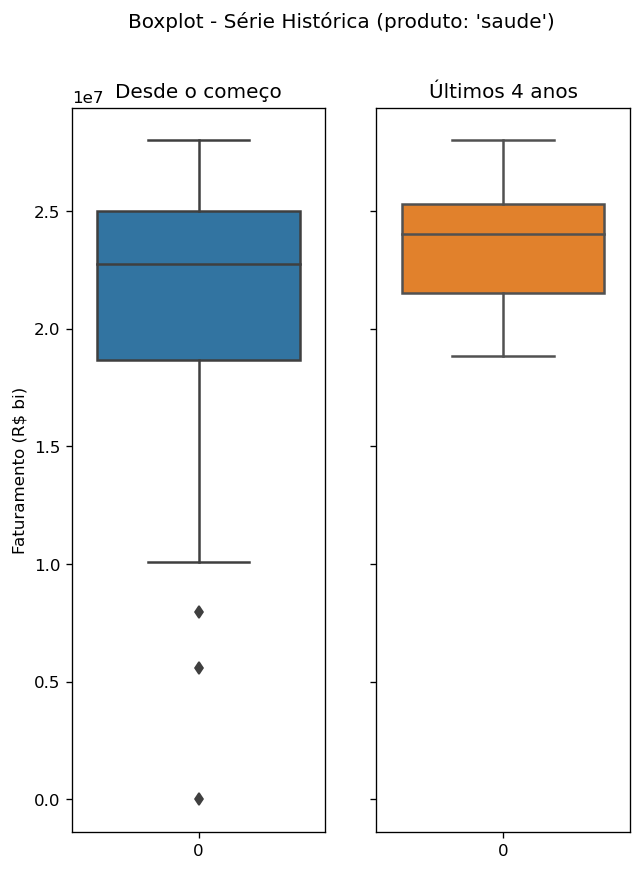

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Aparentemente estávamos corretos ao afirmar que os *outliers* da série completa eram devidos ao *ramp-up* do produto; nos último quatro anos não há mais indicação de valores extremos.

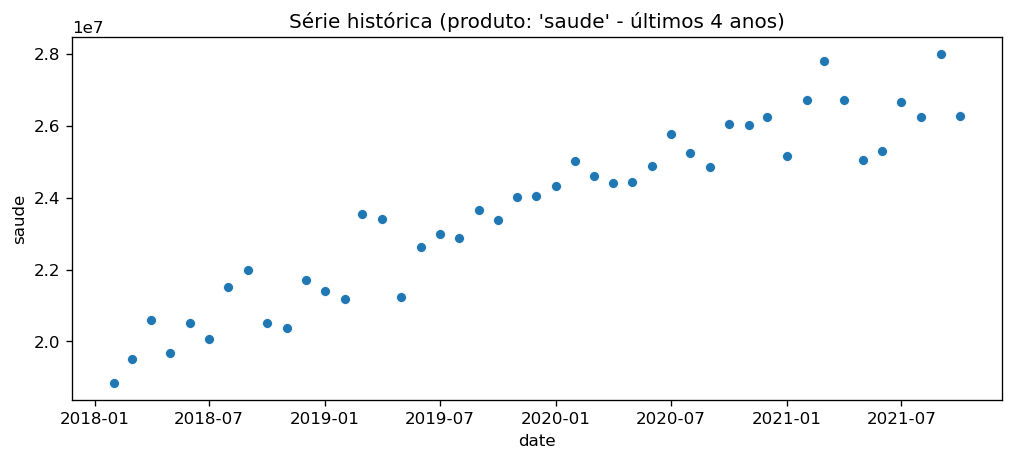

In [13]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

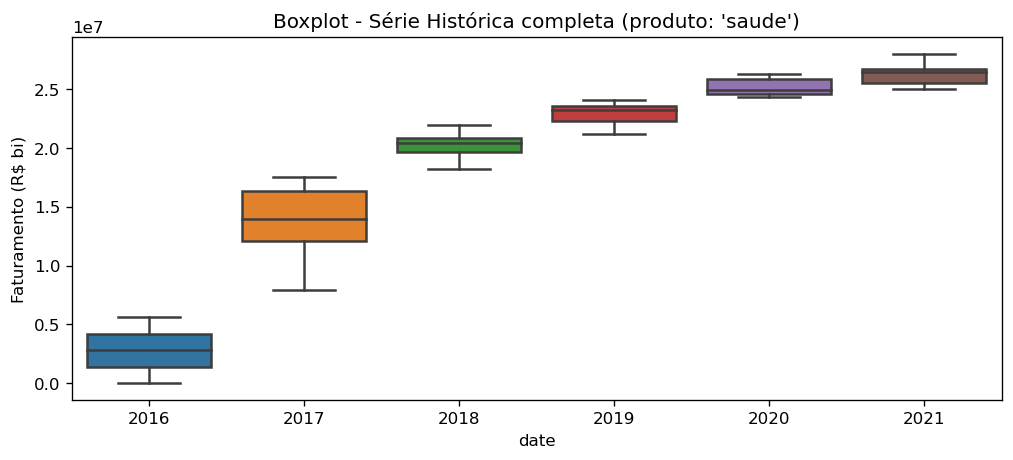

In [14]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

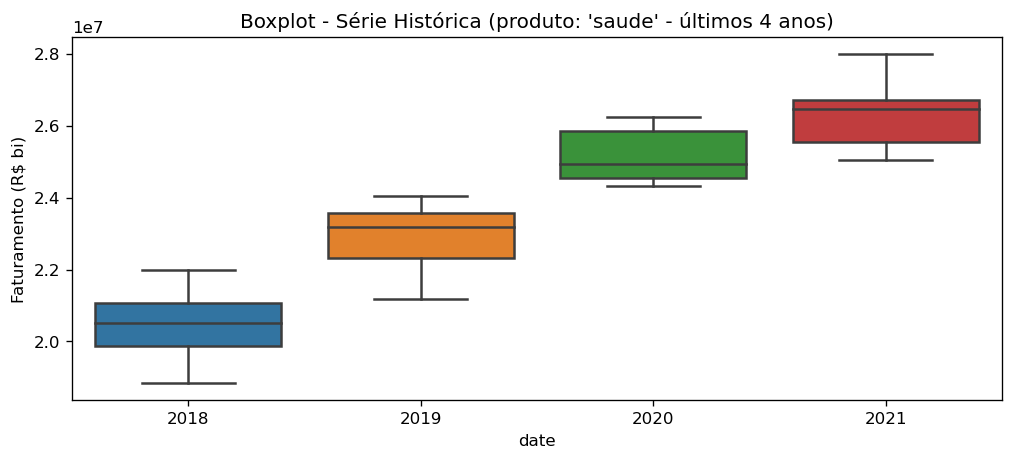

In [15]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [16]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [18]:
testedf = adfuller(fat['2017-07':])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 1.572% < 5%
    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.


Confirmamos que a série é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

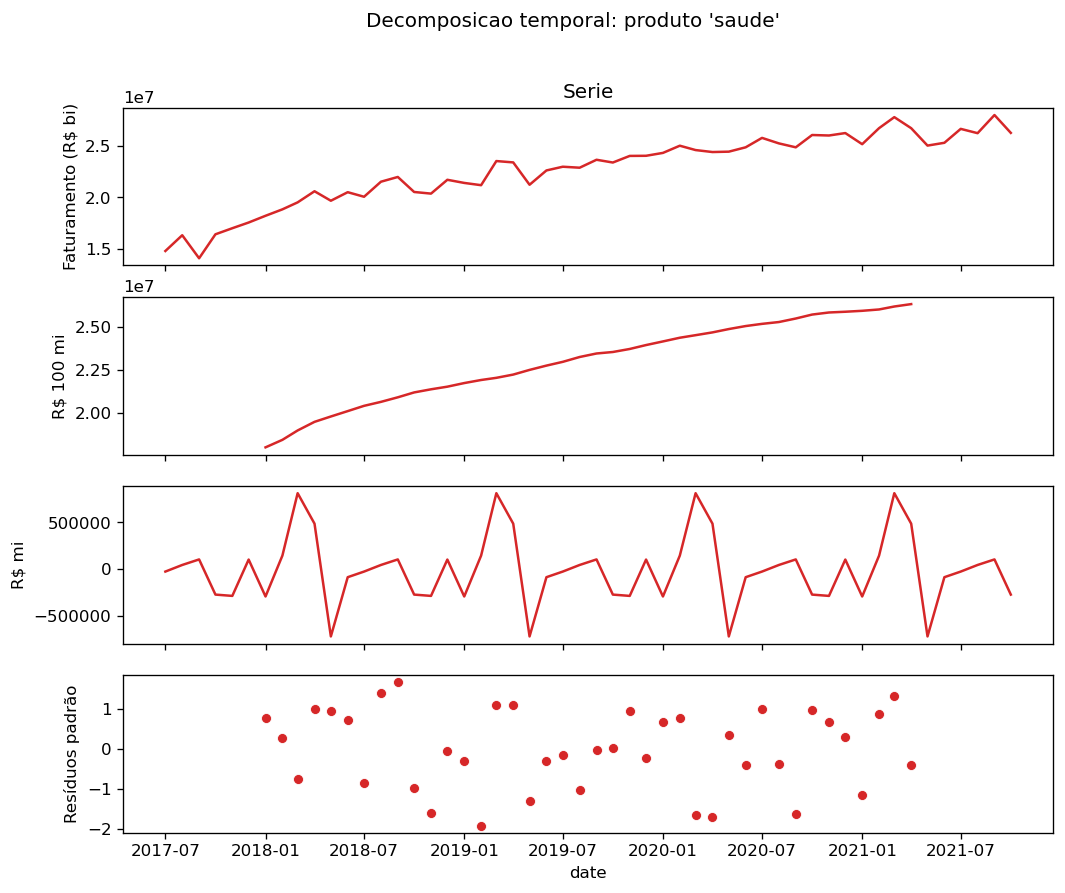

In [21]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat['2017-07':], produto = analise_produto, c = c)

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

É o que ocorre aqui. Os resíduos estão distribuídos aparentemene aleatoriamente.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

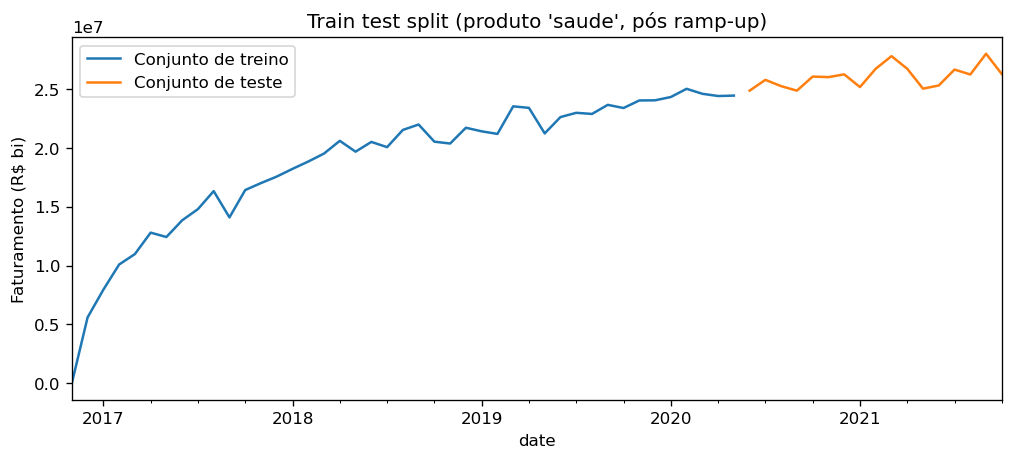

In [67]:
# após ramp-up
fat_modelo = fat

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

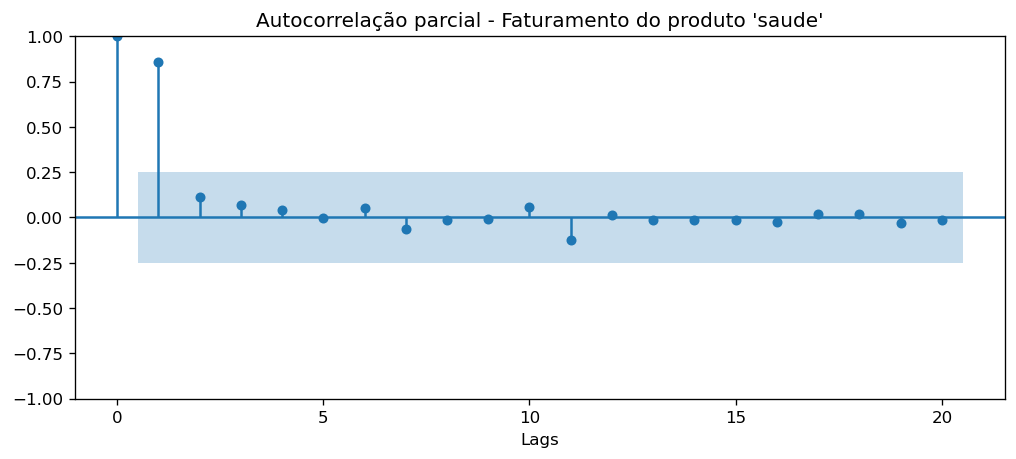

In [41]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

In [52]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 2, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = 0, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    #m = 12,
    seasonal = False,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1271.415, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1296.649, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1280.373, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1276.383, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1294.957, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1266.999, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1272.195, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1265.762, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1265.415, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1264.441, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1270.755, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1264.704, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1263.155, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1262.134, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]          

In [32]:
modelos_aceitaveis = [
    ARIMA(order = (1, 0, 0), seasonal_order=(0, 0, 0, 12), with_intercept = True).fit(y = fat_train),
    ARIMA(order = (0, 1, 0), seasonal_order=(0, 0, 0, 12), with_intercept = True).fit(y = fat_train)
]

In [64]:
modelo = ARIMA(order = (1, 2, 2), with_intercept = True).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [65]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -627.349
Date:                Wed, 17 Nov 2021   AIC                           1264.698
Time:                        19:08:22   BIC                           1273.266
Sample:                             0   HQIC                          1267.818
                                 - 43                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.737e+05   7.78e+04     -2.234      0.026   -3.26e+05   -2.13e+04
ar.L1         -0.9723      0.055    -17.816      0.000      -1.079      -0.865
ma.L1          0.0982      0.203      0.484      0.629      -0.300       0.496
ma.L2         -0.7536      0.145     -5.192      0.000      -1.038      -0.469
sigma2      1.138e+12      0.002   5.26e+14      0.000    1.14e+12    1.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):                 5.11
Prob(Q):                              0.12   Prob(JB):                         0.08
Heteroskedasticity (H):               0.81   Skew:                            -0.50
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+31. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

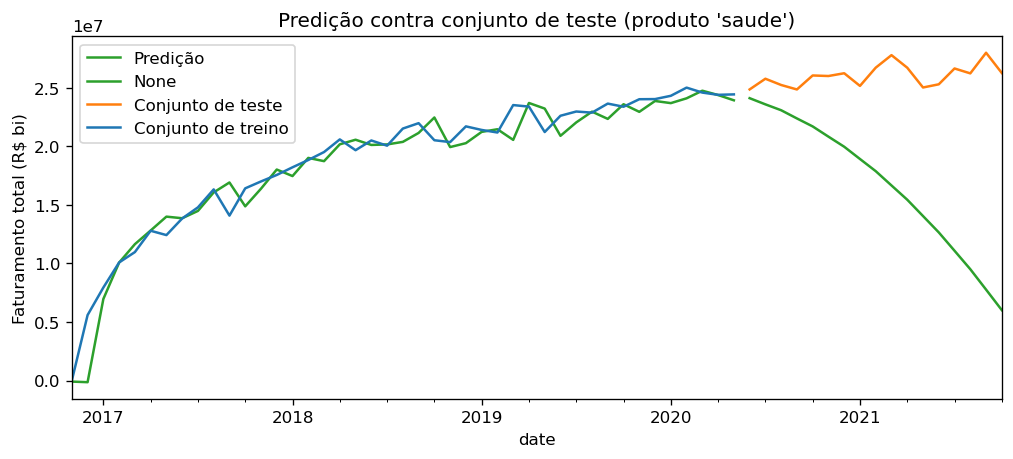

In [66]:
n_test_periods = fat_test.shape[0]
arr_preds = modelo.predict(n_test_periods)


idx = pd.date_range(freq = 'MS', start = fat_test.index[0], periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'preds'

palette = sns.color_palette(None, 4)

preds.plot(label = 'Predição', color = palette[2])
arr_valids = modelo.predict_in_sample()
valids = pd.Series(arr_valids, index = fat_train.index)
valids.plot(color = palette[2])

fat_test.plot(label = 'Conjunto de teste', color = palette[1])
fat_train.plot(label = 'Conjunto de treino')


plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f"Predição contra conjunto de teste (produto '{analise_produto}')")
plt.show()

<AxesSubplot:xlabel='date'>

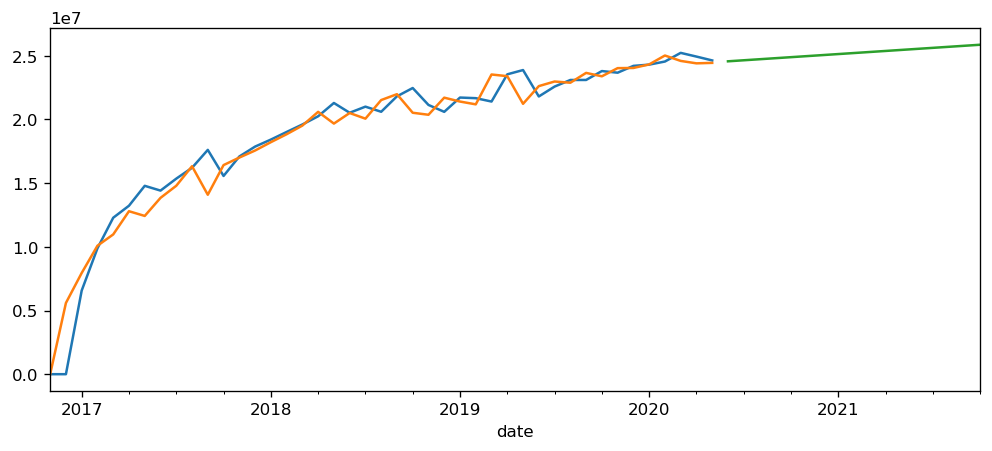

In [62]:
arr_valids = modelo.predict_in_sample()
valids = pd.Series(arr_valids, index = fat_train.index)
valids.plot()
fat_train.plot()
preds.plot()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [48]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
    MAPE: 3.452%
    RMSE: 1.150e+06
     MAE: 9.198e+05
      R²: -59.067%
 R² adj.: -71.303%
